### Mood Predictor Based On Screen Time

In [18]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

sns.set_style('whitegrid')

In [2]:
#load data
df = pd.read_csv('digital_habits_vs_mental_health.csv')
df.head()

,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
0,10.3,2,5.3,4.4,10,5
1,6.5,5,3.5,6.2,8,8
2,9.1,4,2.8,6.6,7,8
3,6.5,3,2.5,6.5,7,9
4,2.1,3,1.2,7.8,2,10


In [3]:
#Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   screen_time_hours            100000 non-null  float64
 1   social_media_platforms_used  100000 non-null  int64  
 2   hours_on_TikTok              100000 non-null  float64
 3   sleep_hours                  100000 non-null  float64
 4   stress_level                 100000 non-null  int64  
 5   mood_score                   100000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 4.6 MB


In [4]:
#Check statisc
df.describe().T

,count,mean,std,min,25%,50%,75%,max
screen_time_hours,100000.0,6.003505,1.987073,1.0,4.7,6.0,7.3,12.0
social_media_platforms_used,100000.0,2.997820,1.414452,1.0,2.0,3.0,4.0,5.0
hours_on_TikTok,100000.0,2.401433,1.079111,0.2,1.6,2.3,3.1,7.2
sleep_hours,100000.0,6.988489,1.466330,3.0,6.0,7.0,8.0,10.0
stress_level,100000.0,6.179590,2.045409,1.0,5.0,6.0,8.0,10.0
mood_score,100000.0,9.060760,1.278470,2.0,8.0,10.0,10.0,10.0


In [5]:
#check for duplicates
df.duplicated().sum()

1865

In [6]:
#drop duplicate
df.drop_duplicates(inplace=True)

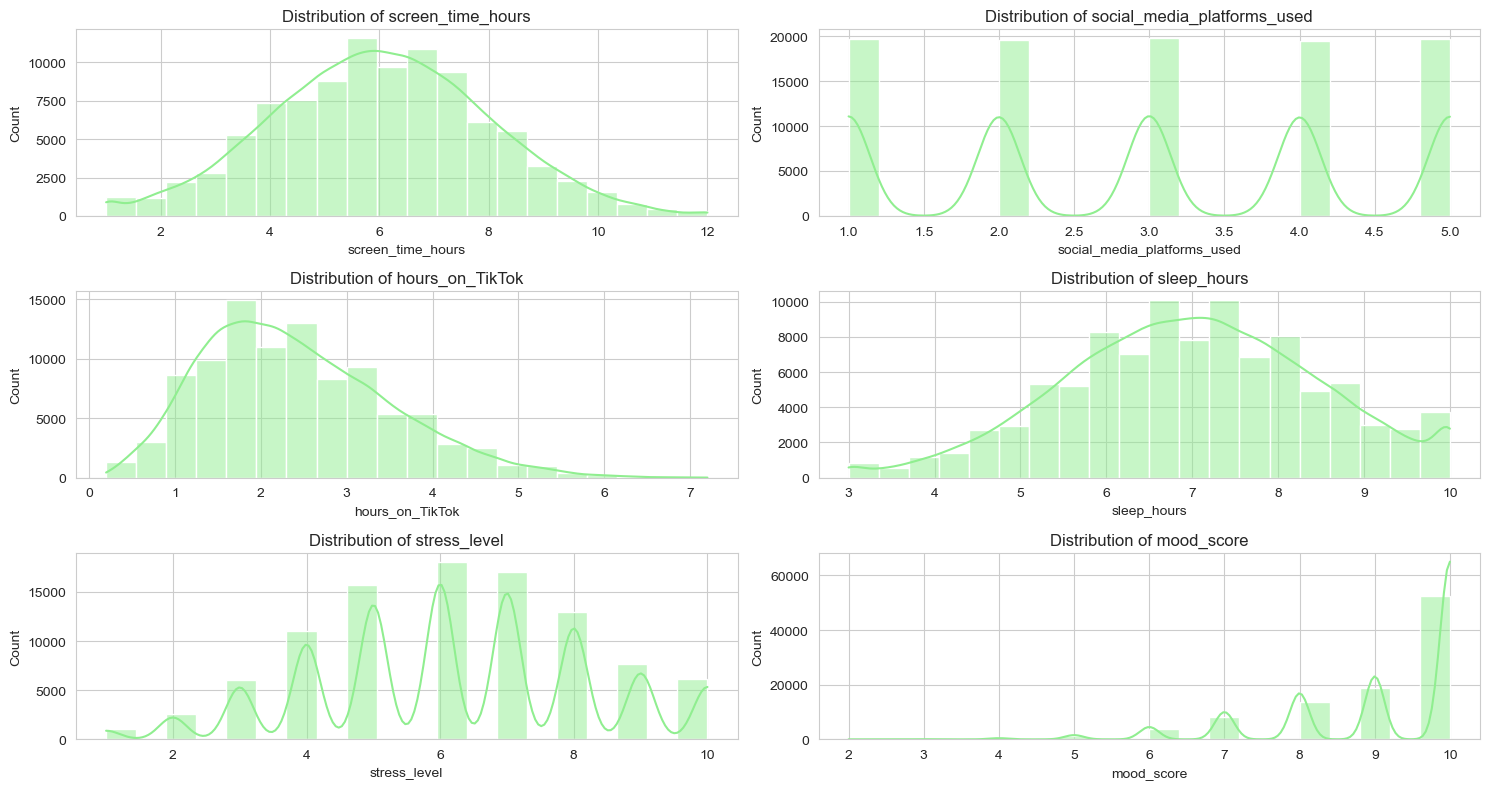

In [7]:
#Visualize the numerical columns
num_cols = df.select_dtypes(np.number).columns

fig, axes = plt.subplots(3,2, figsize=(15,8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, bins=20, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

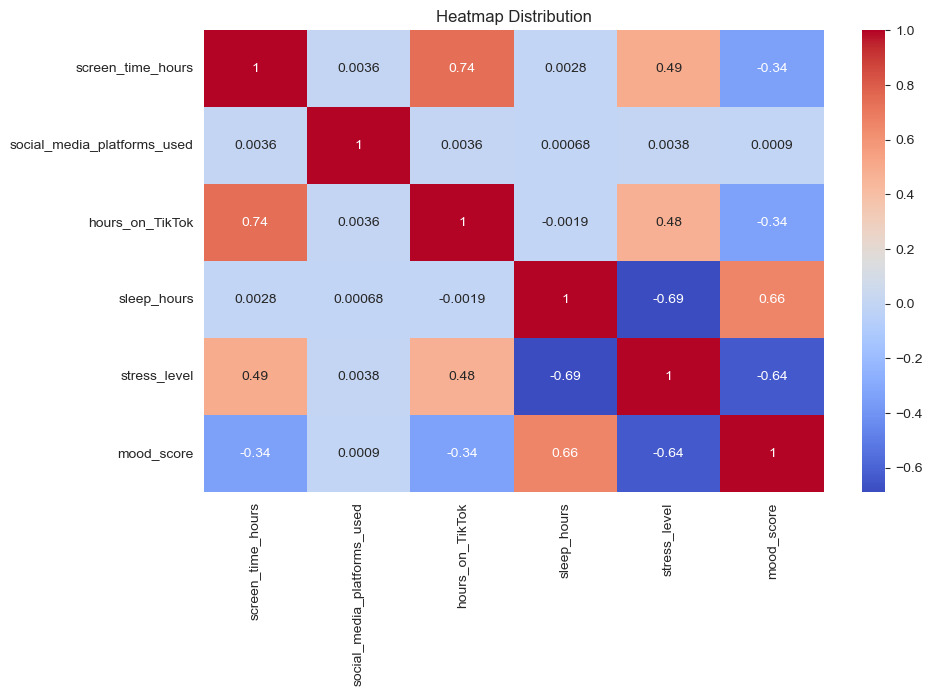

In [8]:
#Correlation
num_col_corr = df.select_dtypes(np.number).corr()
num_col_corr

#Visualize correlation
plt.figure(figsize=(10,6))
sns.heatmap(num_col_corr, annot=True, cmap='coolwarm')
plt.title('Heatmap Distribution')
plt.show()

In [9]:
#Create a new target multi-class column
def model_level(score):
    if score <= 4:
        return 'Bad'
    elif score <= 6:
        return 'Fair'
    else:
        return 'Good'

In [10]:
#Apply function
df['mood_level'] = df['mood_score'].apply(model_level)

In [11]:
df['mood_level'].value_counts()

mood_level
Good    92838
Fair     4894
Bad       403
Name: count, dtype: int64

In [12]:
df.head()

,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score,mood_level
0,10.3,2,5.3,4.4,10,5,Fair
1,6.5,5,3.5,6.2,8,8,Good
2,9.1,4,2.8,6.6,7,8,Good
3,6.5,3,2.5,6.5,7,9,Good
4,2.1,3,1.2,7.8,2,10,Good


In [13]:
#Split data into Target and features
X = df.drop(columns=['mood_level', 'mood_score'])
y = df['mood_level']

#Split into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
#Get numerical column
num_col = ['screen_time_hours', 'social_media_platforms_used', 'hours_on_TikTok',
            'sleep_hours', 'stress_level']

In [16]:
#Build a preprocessor pipeline
numerical_column = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_column, num_col)
])

In [17]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['screen_time_hours',
                                  'social_media_platforms_used',
                                  'hours_on_TikTok', 'sleep_hours',
                                  'stress_level'])])

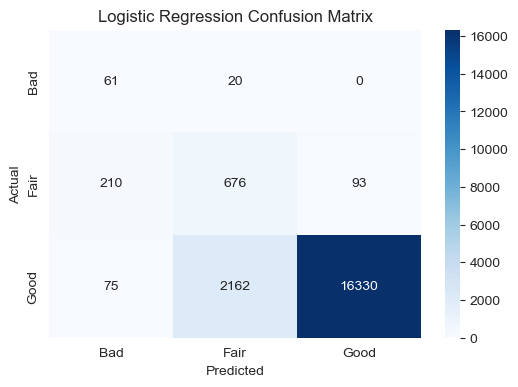

              precision    recall  f1-score   support

         Bad       0.18      0.75      0.29        81
        Fair       0.24      0.69      0.35       979
        Good       0.99      0.88      0.93     18567

    accuracy                           0.87     19627
   macro avg       0.47      0.77      0.52     19627
weighted avg       0.95      0.87      0.90     19627



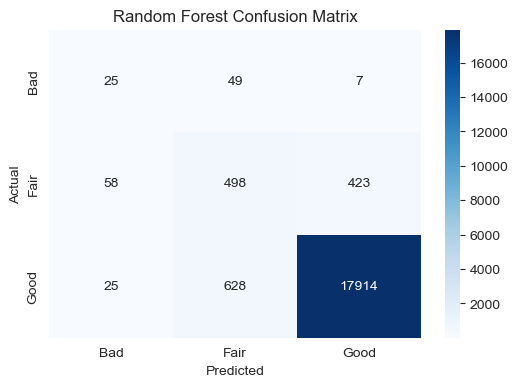

              precision    recall  f1-score   support

         Bad       0.23      0.31      0.26        81
        Fair       0.42      0.51      0.46       979
        Good       0.98      0.96      0.97     18567

    accuracy                           0.94     19627
   macro avg       0.54      0.59      0.57     19627
weighted avg       0.95      0.94      0.94     19627



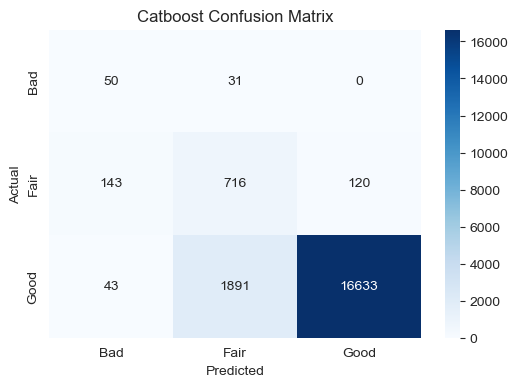

              precision    recall  f1-score   support

         Bad       0.21      0.62      0.32        81
        Fair       0.27      0.73      0.40       979
        Good       0.99      0.90      0.94     18567

    accuracy                           0.89     19627
   macro avg       0.49      0.75      0.55     19627
weighted avg       0.95      0.89      0.91     19627

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261
[LightGBM] [Info] Number of data points in the train set: 222813, number of used features: 5
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


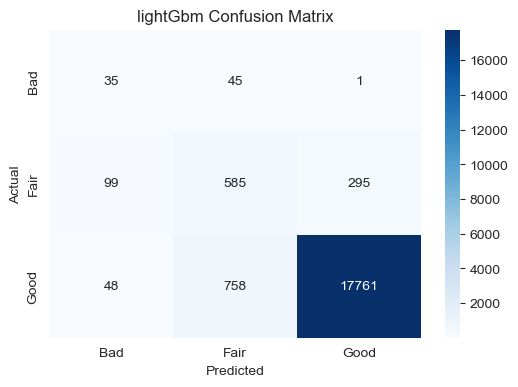

              precision    recall  f1-score   support

         Bad       0.19      0.43      0.27        81
        Fair       0.42      0.60      0.49       979
        Good       0.98      0.96      0.97     18567

    accuracy                           0.94     19627
   macro avg       0.53      0.66      0.58     19627
weighted avg       0.95      0.94      0.94     19627



In [19]:
#Build a model pipeline
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', multi_class='multinomial'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Catboost': CatBoostClassifier(iterations=300, depth=3, learning_rate=0.1, loss_function='MultiClass',verbose=0),
    'lightGbm': LGBMClassifier()
}

results = {
    'Models':[],
    'Test Accuracy': [],
    'Train Accuracy': []
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier',  model)
    ])

    pipeline.fit(X_train,y_train)#predictions for train and test
    test_pred = pipeline.predict(X_test)
    train_pred = pipeline.predict(X_train)

    #Accuracy score for train and test
    test_acc = accuracy_score(y_test, test_pred)
    train_acc = accuracy_score(y_train, train_pred)

    #Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=pipeline.classes_ , yticklabels=pipeline.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #Classification Report
    cr = classification_report(y_test, test_pred)
    print(cr)

    #append results
    results['Models'].append(name)
    results['Test Accuracy'].append(test_acc)
    results['Train Accuracy'].append(train_acc)



Catboost is the most balanced performing model, as it captures most of the bad, tho it has less accuracy score, but it is best performing while trying to capture the Bad too and not only the Good or Fair

In [20]:
best_model = CatBoostClassifier(iterations=300, depth=3, learning_rate=0.1, loss_function='MultiClass',verbose=0)


In [21]:
best_model

In [22]:
final_model = pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', best_model)
    ])

In [23]:
final_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['screen_time_hours',
                                                   'social_media_platforms_used',
                                                   'hours_on_TikTok',
                                                   'sleep_hours',
                                                   'stress_level'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001DED1B7EBA0>)])

In [24]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['screen_time_hours',
                                                   'social_media_platforms_used',
                                                   'hours_on_TikTok',
                                                   'sleep_hours',
                                                   'stress_level'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001DED1B7EBA0>)])